In [7]:
from typing import List
import sys
sys.path.append('C:/Users/TomFi/Desktop/Cours/Projet IA/neuroforest-master')
sys.path.append('C:/Users/TomFi/Desktop/Cours/Projet IA/deepHL')
import numpy as np
import json
import os
import time
from tqdm import tqdm
from IPython import display
from PIL import Image, ImageDraw, ImageFont
from sklearn.preprocessing import MinMaxScaler


from main import to_vect, Coordinates, calculate_asrs, classify_asrs, dataloader, dataloader_2024
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


In [39]:
def create_batches(dataloader, session_type: str, batch_size: int, 
                   subsample : bool = False, asrs_calc = classify_asrs):
    trajectories = []
    asrs = []

    for sample in dataloader:
        session = sample[session_type]
        if session is not None:
            if sample.answers is not None:
                player_coords = np.array([c["coord"].to_vect() for c in session.player_coords])
                player_coords = player_coords[:, [0, 2]]  # Keep only x and z coordinates
                asrs_score = asrs_calc(sample.answers)

                trajectories.append(player_coords)
                asrs.append(asrs_score)

    # Pad / Truncate trajectories
    length = 30000
    padded_trajectories = []
    for traj in trajectories:
        if len(traj) < length:
            padded_traj = np.pad(traj, ((0, length - len(traj)), (0, 0)), mode='edge')
        else :
            padded_traj = traj
        truncated_traj = padded_traj[:length]
        padded_trajectories.append(truncated_traj)
    player_coords = np.array(padded_trajectories)

    # Subsample trajectories
    if subsample:
        scale = 20
        length = length // scale
        trajectories = np.array([np.array_split(player_coords, scale) for player_coords in padded_trajectories])
        trajectories = np.concatenate(trajectories, axis=0)
        trajectories = np.array([coords - coords[0] for coords in trajectories])
        asrs = np.array([asrs_score for asrs_score in asrs for _ in range(scale)])

    # Shuffle trajectories
    tensor_trajectories = torch.tensor(trajectories, dtype=torch.float32)
    seed = 42
    permute = torch.randperm(len(tensor_trajectories), generator=torch.Generator().manual_seed(seed))
    tensor_trajectories = tensor_trajectories[permute]
    asrs = asrs[permute]

    # Create batches
    num_batches = min(len(tensor_trajectories), len(asrs)) // batch_size
    if len(asrs) == len(trajectories):
        batches = tensor_trajectories[:num_batches * batch_size].view(num_batches, batch_size, length, 2)
        asrs = torch.tensor(np.array(asrs[:num_batches * batch_size])).view(num_batches, batch_size)
        # Reduce the sample rate
        batches = batches[:, :, ::25]    

    return batches, asrs

In [49]:
# Create batches for "uniform" and "patchy" session types
batch_size = 60
uniform_batches,asrs = create_batches(dataloader, "uniform", batch_size, subsample=True)
high_probability_adhd = torch.Tensor((np.array(asrs) >= 4).astype(int))


# For each trajectory, select only 1 point every second, linearly spaced
print(f"Uniform batches shape: {uniform_batches.shape}")

# Split the batches to a train and test
x_train = uniform_batches
y_train = high_probability_adhd
# x_test = uniform_batches[-1]
# y_test = high_probability_adhd[-1]
print(f"Train batches shape: {x_train.shape}")
print(f"Train target batches shape: {y_train.shape}")


# patchy_batches,_ = create_batches(dataloader, "patchy", batch_size)
# print(f"Uniform batches shape: {uniform_batches.shape}")
# print(f"Patchy batches shape: {patchy_batches.shape}")

print(f"ASRS scores: {asrs}")

Uniform batches shape: torch.Size([13, 60, 60, 2])
Train batches shape: torch.Size([13, 60, 60, 2])
Train target batches shape: torch.Size([13, 60])
ASRS scores: tensor([[ 0,  2,  5,  5,  6,  1, 12,  6,  2,  4,  6,  6,  5,  5,  2,  5,  3, 12,
          4,  3,  5,  6,  5,  6,  3,  5,  3,  6,  6,  5,  7,  6,  8,  6,  7,  6,
         12,  5,  0,  4,  8,  2, 12,  7,  5,  7,  2,  3,  5,  8,  3,  7,  7, 11,
          5,  1,  7,  0,  6,  5],
        [11,  6, 10,  1,  0,  6,  5,  3,  5, 12,  5,  8,  8,  3,  4,  7, 12,  5,
          5,  5,  5,  3,  7,  6, 11,  5,  2,  7, 12,  4,  1,  5,  8,  4,  8,  2,
          1,  5,  4,  2, 10,  1,  7, 12,  5, 11,  4,  7,  5,  5,  6,  4,  4,  1,
         12, 12,  1,  5,  4,  5],
        [ 6,  6, 11,  5,  7,  6, 12,  4,  2,  6,  8, 12, 12,  5,  5,  6,  1,  5,
          6,  2,  6, 11,  0,  5,  7, 11,  5,  2,  7,  1,  5,  5,  5,  2, 11,  1,
          4,  6, 12,  2, 12,  8,  1,  7,  0,  7,  4,  8,  7,  3,  5,  0,  7,  4,
         12, 12,  5,  5,  4,  5],
       

In [56]:
test_batches, test_asrs = create_batches(dataloader_2024, "uniform", batch_size=batch_size, subsample=True)
test_HP_adhd = torch.Tensor((np.array(test_asrs) >= 4).astype(int))

print(f"Test batches shape: {test_batches.shape}")
print(f"Test ASRS scores: {test_asrs}")

Test batches shape: torch.Size([3, 60, 60, 2])
Test ASRS scores: tensor([[8, 2, 0, 4, 7, 4, 4, 2, 5, 5, 4, 8, 4, 7, 4, 2, 5, 2, 2, 4, 0, 3, 4, 4,
         4, 0, 2, 8, 7, 4, 3, 5, 4, 4, 4, 7, 8, 0, 4, 3, 0, 3, 4, 2, 3, 5, 0, 2,
         8, 3, 7, 8, 2, 3, 0, 0, 4, 8, 7, 3],
        [7, 8, 4, 8, 8, 2, 8, 8, 7, 5, 2, 2, 7, 8, 8, 8, 7, 8, 0, 8, 4, 8, 4, 8,
         4, 3, 7, 5, 3, 3, 5, 0, 0, 4, 5, 0, 4, 4, 7, 8, 2, 3, 8, 0, 5, 2, 8, 8,
         2, 3, 8, 4, 8, 5, 4, 8, 0, 8, 5, 3],
        [7, 3, 7, 8, 4, 4, 5, 5, 4, 7, 0, 4, 2, 5, 4, 5, 2, 2, 4, 8, 8, 0, 4, 4,
         8, 8, 8, 4, 4, 7, 3, 4, 2, 5, 4, 8, 5, 5, 8, 3, 7, 8, 8, 5, 7, 0, 8, 4,
         0, 2, 3, 8, 8, 4, 3, 3, 0, 7, 7, 0]], dtype=torch.int32)


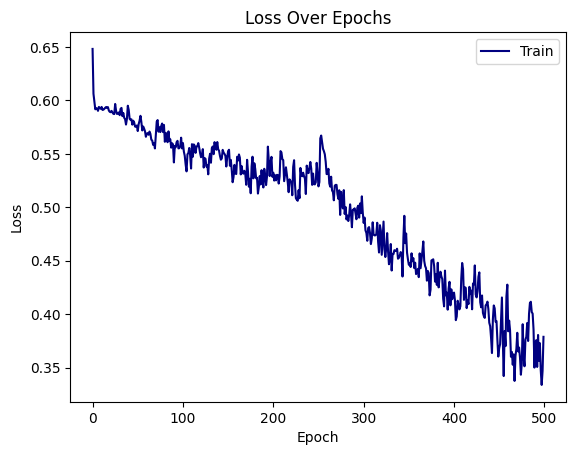

In [77]:
class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, seq_len):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1, dropout=dropout)
        self.dense1 = nn.Linear(hidden_dim, 1)
        self.dense2 = nn.Linear(seq_len,1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        seq_len = lstm_out.size(1)
        lstm_out = lstm_out.permute(1, 0, 2)
        attention_out = self.attention(lstm_out, lstm_out, lstm_out)[0]
        dense_out = self.dense1(attention_out).view(-1, seq_len)
        dense_out = self.dense2(dense_out)
        probability = self.activation(dense_out)
        return probability

# Define the model parameters
seq_len = x_train.shape[2]
input_dim = 2  # x and z coordinates
hidden_dim = 64
num_layers = 4
dropout = 0.5

# Instantiate the model
model = LSTMWithAttention(input_dim, hidden_dim, num_layers, dropout, seq_len)
print(model)

# Define the loss function and optimizer
criterion = nn.BCELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# Example training loop
num_epochs = 500
for epoch in range(num_epochs):
    train_loss = 0
    for batch in range(x_train.shape[0]):
        x_train_batch = uniform_batches[batch]
        y_train_batch = high_probability_adhd[batch]
        
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(x_train_batch)
        loss = criterion(outputs.squeeze(), torch.tensor(y_train_batch, dtype=torch.float32))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss += loss.item()/x_train.shape[0]
        
    # add validation on test set
    # val_loss = criterion(model(x_test).squeeze(), torch.tensor(y_test, dtype=torch.float32)).item()/x_test.shape[0]

    # print(f'Epoch {epoch+1}/{num_epochs}, batch {batch+1}/{x_train.shape[0]}, Loss: {train_loss}, Val Loss: {val_loss}')
    
    # Dynamic plot to showcase the evolution of the loss
    if epoch == 0:
        plt.ion()
        fig, ax = plt.subplots()
        losses = []
        val_losses = []

    losses.append(train_loss)
    # val_losses.append(val_loss)
    ax.clear()
    ax.plot(losses, label='Train', color = 'navy')
    # ax.plot(val_losses, label='Validation', color = 'r')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss Over Epochs')
    ax.legend()
    display.display(fig)
    display.clear_output(wait=True)

In [30]:
print(model)
torch.save(model.state_dict(), 'LSTM_attention.pkl')

LSTMWithAttention(
  (lstm): LSTM(2, 64, num_layers=4, batch_first=True, dropout=0.5)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (dense1): Linear(in_features=64, out_features=1, bias=True)
  (dense2): Linear(in_features=1200, out_features=1, bias=True)
  (activation): Sigmoid()
)


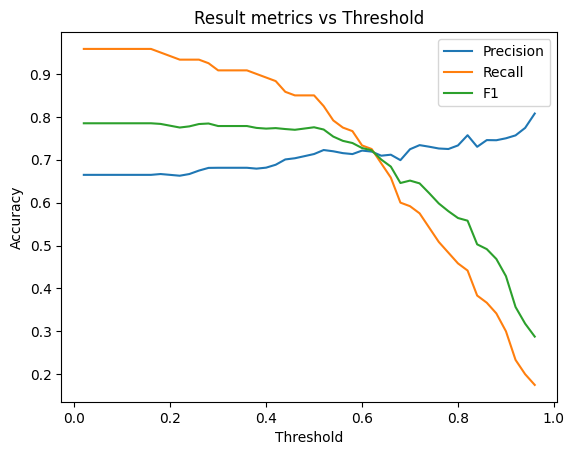

In [79]:
outputs = []
for batch in range(test_batches.shape[0]):
    x_test_batch = test_batches[batch]
    outputs.append(model(x_test_batch).squeeze().detach().numpy())
outputs = np.array(outputs).flatten()
test_HP_adhd = np.array(test_HP_adhd).flatten()
threshold = np.arange(0.02, 0.98, 0.02)
accuracy, precision, recall = [], [], []
for t in threshold:
    tp = np.sum((outputs > t) & (test_HP_adhd == 1))
    tn = np.sum((outputs <= t) & (test_HP_adhd == 0))
    fp = np.sum((outputs > t) & (test_HP_adhd == 0))
    fn = np.sum((outputs <= t) & (test_HP_adhd == 1))
    # print(f"TP : {tp}, TN : {tn}, FP : {fp}, FN : {fn}")
    precision.append(tp / (tp + fp))
    recall.append(tp / (tp + fn))
f1 = 2 * np.array(precision) * np.array(recall) / (np.array(precision) + np.array(recall))
plt.plot(threshold, precision, label = 'Precision')
plt.plot(threshold, recall, label = 'Recall')
plt.plot(threshold, f1, label = 'F1')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Result metrics vs Threshold')
plt.legend()
plt.show()